In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import itertools
from operator import itemgetter
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers, utils, initializers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
import linkpred
from linkpred.evaluation import Pair
import seaborn as sns

In [4]:
import sklearn.metrics as metrics

In [5]:
from gensim.models import Word2Vec

In [6]:
with open('universe_1057.pickle', 'rb') as f:
    universe_1057 = pickle.load(f)

In [7]:
embedding_pickle_1057 = pd.read_pickle('embedding_pickle_1057.csv')

In [8]:
edges_1057 = pd.read_pickle('edges_original_1057.csv')

In [9]:
all_unconnected_pairs_1057 = []

In [10]:
def check_isequal(x, a, b):
    if x[0] == a:
        if x[1] == b:
            return True
    return False

In [11]:
for ui in universe_1057:
    is_not = False
    for i,j in edges_1057.values:
        if check_isequal(ui, i, j):
            is_not = True
            break
    if not is_not:
        all_unconnected_pairs_1057.append((ui[0], ui[1]))

In [12]:
word2vec_1057 = Word2Vec.load("word2vec_1057.model")

Collegamenti inesistenti => target negativo

In [13]:
node_1_unlinked = [word2vec_1057.wv[i[0]] for i in all_unconnected_pairs_1057]
node_2_unlinked = [word2vec_1057.wv[i[1]] for i in all_unconnected_pairs_1057]

data_1057 = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data_1057['link'] = 0

In [14]:
data_1057

,node_1,node_2,link
0,"[-0.004029544, 0.005909367, -0.009431077, -0.0...","[-0.002808011, 0.008729938, -0.0030782113, -0....",0
1,"[0.0052940776, -0.00034964527, -0.0025018135, ...","[-0.004768085, -0.0022963774, 0.0057055135, 0....",0
2,"[-0.002272107, 0.0069066547, -0.009370051, -0....","[-0.00038697114, 7.716117e-05, 0.008939102, -0...",0
3,"[0.0025233123, 0.007877934, 0.0061169583, 0.00...","[-0.009035716, 0.009190363, 0.007643464, -0.00...",0
4,"[-0.00788017, -0.009050664, 0.0042381403, -0.0...","[-0.0018274903, -0.0011091642, 0.0048377938, 0...",0
...,...,...,...
3888,"[-0.00762396, -0.0095786825, -0.0043723052, 0....","[-0.0018528695, 0.006204947, -0.006871443, 0.0...",0
3889,"[-0.0051412056, -0.0051100506, -0.005624291, -...","[0.007287868, 0.001381168, -0.0073154424, 0.00...",0
3890,"[-0.005842145, -0.0060832286, -0.007844865, 0....","[-0.0018528695, 0.006204947, -0.006871443, 0.0...",0
3891,"[-0.004029544, 0.005909367, -0.009431077, -0.0...","[0.0001300528, -0.007096527, 0.008575471, -0.0...",0


In [15]:
H_1057 = nx.read_graphml("H_1057.graphml")

In [16]:
print(nx.info(H_1057))

Name: 
Type: Graph
Number of nodes: 97
Number of edges: 1486
Average degree:  30.6392


In [17]:
def omissibile_links(G, df_edges):
    initial_node_count = len(G.nodes)

    fb_df_temp = df_edges.copy()

    # empty list to store removable links
    omissible_links_index = []

    for i in tqdm(df_edges.index.values):

      # remove a node pair and build a new graph
      G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "first", "second", create_using=nx.Graph())

      # check there is no spliting of graph and number of nodes is same
      if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
        omissible_links_index.append(i)
        fb_df_temp = fb_df_temp.drop(index = i)
    return omissible_links_index

In [18]:
omissible_links_1057 =  omissibile_links(H_1057, edges_1057)

100%|█████████████████████████████████████████████████████████████████████████████| 1486/1486 [00:02<00:00, 550.34it/s]


In [19]:
len(edges_1057)

1486

In [20]:
len(omissible_links_1057)

1390

In [21]:
len(universe_1057)

4656

In [22]:
embedding_pickle_1057

,first,second
0,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[0.00579291, -0.009710455, -0.0018261216, 0.00..."
1,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.005854544, 0.004006448, 0.0012593302, -0.0..."
2,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.009007853, 0.010250819, -0.00019994462, -0..."
3,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.004031753, 0.008645464, 0.0069751577, -0.0..."
4,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[0.004984007, 0.0060267765, 0.0017293151, 0.00..."
...,...,...
1481,"[0.009549069, 0.004714752, -0.002151297, -0.00...","[0.0012623224, 0.0013071975, -0.0043557603, -0..."
1482,"[0.009549069, 0.004714752, -0.002151297, -0.00...","[-0.00026423682, 0.009727423, -0.0058031147, -..."
1483,"[-0.00910064, 0.004200009, -0.0066999607, 0.00...","[-0.005854544, 0.004006448, 0.0012593302, -0.0..."
1484,"[-0.00026423682, 0.009727423, -0.0058031147, -...","[-0.005854544, 0.004006448, 0.0012593302, -0.0..."


In [23]:
fb_df_ghost_1057 = embedding_pickle_1057.loc[omissible_links_1057]

In [24]:
fb_df_ghost_1057

,first,second
0,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[0.00579291, -0.009710455, -0.0018261216, 0.00..."
1,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.005854544, 0.004006448, 0.0012593302, -0.0..."
2,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.009007853, 0.010250819, -0.00019994462, -0..."
3,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[-0.004031753, 0.008645464, 0.0069751577, -0.0..."
4,"[-0.0067305905, 0.008604753, -0.009962158, 0.0...","[0.004984007, 0.0060267765, 0.0017293151, 0.00..."
...,...,...
1475,"[-0.009666364, 0.0047051175, 0.005463008, 0.00...","[-0.005854544, 0.004006448, 0.0012593302, -0.0..."
1476,"[-0.009666364, 0.0047051175, 0.005463008, 0.00...","[0.0012623224, 0.0013071975, -0.0043557603, -0..."
1477,"[-0.009666364, 0.0047051175, 0.005463008, 0.00...","[0.009549069, 0.004714752, -0.002151297, -0.00..."
1479,"[-0.009666364, 0.0047051175, 0.005463008, 0.00...","[-0.00910064, 0.004200009, -0.0066999607, 0.00..."


In [25]:
# create dataframe of removable edges
fb_df_ghost_1057 = embedding_pickle_1057.loc[omissible_links_1057]

fb_df_ghost_1057 = fb_df_ghost_1057.rename(columns={"first": "node_1", "second": "node_2"})
# add the target variable 'link'
fb_df_ghost_1057['link'] = 1

data_1057 = data_1057.append(fb_df_ghost_1057[['node_1', 'node_2', 'link']], ignore_index=True)

In [26]:
data_1057['link'].value_counts()

0    3893
1    1390
Name: link, dtype: int64

In [27]:
data_1057.to_pickle("data_1057.csv")

----------------- Lettura dati -------------------

In [28]:
data_1057 = pd.read_pickle('data_1057.csv')

# 2 - Classificatori

In [29]:
X_1057 = []
for i in range(data_1057.shape[0]):
    first = data_1057.iloc[i][0]
    second = data_1057.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_1057.append(mixed)

In [30]:
xtrain_1057, xtest_1057, ytrain_1057, ytest_1057 = train_test_split(np.asarray(X_1057), data_1057['link'], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=data_1057['link'])

### 1 - DecisionTree

In [31]:
from sklearn import tree
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [32]:
# Set the parameters by cross-validation
tuned_parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20],
}
scores = ['roc_auc']

In [33]:
def builtGridSearch( X_train, X_test, y_train, y_test, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("------- Score = " + str(score) + " ------- \n")
        model = tree.DecisionTreeClassifier()
        k_fold = StratifiedKFold(n_splits=5, random_state=42)
        
        print("> Fold = " + str(k_fold) + "\n")
        clf = GridSearchCV(model, tuned_parameters, error_score='raise', cv=5, scoring = score, return_train_score=True)

        clf.fit(X_train, y_train)

        print("> Best Parameter set: \n")
        best = clf.best_params_
        print(best)
        
        print("\n> Grid scores:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        
        parameters = {"criterion": [], "max_depth": [], "min_samples_leaf": [], "min_samples_split": []}
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
            parameters["criterion"].append(params["criterion"])

            if(params["max_depth"] == None):
                parameters["max_depth"].append(0)
            else:
                parameters["max_depth"].append(params["max_depth"])

            #parameters["max_depth"].append(params["max_depth"])
            parameters["min_samples_leaf"].append(params["min_samples_leaf"])
            parameters["min_samples_split"].append(params["min_samples_split"])
        
        print("-> Report\n") 
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print("\n")
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))

        
        # Creazione del csv
        d = {score: means, 'std_dev': stds*2, 'criterion': parameters["criterion"], "max_depth": parameters["max_depth"], "min_samples_leaf": parameters["min_samples_leaf"], "min_samples_split": parameters["min_samples_split"]}
        
        dataF = pd.DataFrame(data=d)
        
        dataF.to_csv("result_DT_gridsearch.csv",index=False, header=True)
        

        print("...........RESULTS FOR TRAINING.........")
        print("........................................")
        means = clf.cv_results_['mean_train_score']
        stds = clf.cv_results_['std_train_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))        
        
        print("____________________________________________")
        
        optimals[score] = best
    return optimals

In [34]:
optimals_1057 = builtGridSearch(xtrain_1057, xtest_1057, ytrain_1057, ytest_1057, tuned_parameters, scores)

------- Score = roc_auc ------- 



ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [36]:
optimals_1057

NameError: name 'optimals_1057' is not defined

# 1 - DecisionTree_Bilanciato

In [35]:
remove_n = data_1057['link'].value_counts()[0] - data_1057['link'].value_counts()[1]
remove_n

2503

In [36]:

df = data_1057.copy()
drop_indices = np.random.choice(df[df["link"]==0].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
print(df_subset['link'].value_counts())

X_sbset_1057 = []
for i in range(df_subset.shape[0]):
    first = df_subset.iloc[i][0]
    second = df_subset.iloc[i][1]
    mixed = np.concatenate((first, second), 0)
    X_sbset_597.append(mixed)
    
    
xtrain_sb_1057, xtest_sb_1057, ytrain_sb_1057, ytest_sb_1057 = train_test_split(np.asarray(X_sbset_1057), df_subset["link"], 
                                                test_size = 0.3, 
                                                random_state = 35,
                                                stratify=df_subset["link"])


0    1390
1    1390
Name: link, dtype: int64


NameError: name 'X_sbset_597' is not defined

In [37]:
optimals_sb_1057 = builtGridSearch(xtrain_sb_1057, xtest_sb_1057, ytrain_sb_1057, ytest_sb_1057, tuned_parameters, scores)

NameError: name 'xtrain_sb_1057' is not defined

In [38]:
optimals_sb_1057

NameError: name 'optimals_sb_1057' is not defined

### 3 - LinearSVC

In [39]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [40]:
# Set the parameters by cross-validation
tuned_parameters = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0)
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

scores = ['roc_auc']

def gridsearch_linearsvc(X_train, y_train, X_test, y_test, k_fold, tuned_parameters, scores):
    optimals = {}
    for score in scores:
        print("# Tuning hyper-parameters for ----> %s" % score)
        print()

        svm = LinearSVC()

        clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)

        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        print("**** Matrice di Confusione *****")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        print(' True negative: %d False negative: %d' % (tn, fn))
        print(' True positive: %d False positive: %d' % (tp, fp))
        print("____________________________________________")
        optimals[score] = clf.best_params_
    return optimals

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

In [43]:
optimals_1057 = gridsearch_linearsvc(xtrain_1057,  ytrain_1057, xtest_1057, ytest_1057, k_fold, tuned_parameters, scores)

NameError: name 'gridsearch_linearsvc' is not defined

In [44]:
optimals_1057

NameError: name 'optimals_1057' is not defined

# 4 - NN

In [45]:
def build_model_1( X_train):
    optimizer='adagrad'
    #optimizer='adam'
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(32, input_dim=n_feature, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    # Linear
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["AUC"])
    return model

In [46]:
def build_model_2(X_train):
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    # Linear
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
    sgd = optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["AUC"])
    return model

In [47]:
model1_1057 = build_model_1(xtrain_1057)
history1_1057 = model1_1057.fit(xtrain_1057, ytrain_1057, validation_data=(xtest_1057, ytest_1057), epochs=30, batch_size=10).history

model2_1057 = build_model_2(xtrain_1057)
history2_1057 = model2_1057.fit(xtrain_1057, ytrain_1057, validation_data=(xtest_1057, ytest_1057), epochs=30, batch_size=50).history

Epoch 1/30
378/378 [==============================] - 2s 2ms/step - loss: 0.6108 - auc: 0.4868 - val_loss: 0.5791 - val_auc: 0.5102
Epoch 2/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5737 - auc: 0.4993 - val_loss: 0.5712 - val_auc: 0.5034
Epoch 3/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5710 - auc: 0.5022 - val_loss: 0.5706 - val_auc: 0.5069
Epoch 4/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5708 - auc: 0.5043 - val_loss: 0.5706 - val_auc: 0.5174
Epoch 5/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5707 - auc: 0.5058 - val_loss: 0.5706 - val_auc: 0.5037
Epoch 6/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5707 - auc: 0.4996 - val_loss: 0.5705 - val_auc: 0.5068
Epoch 7/30
378/378 [==============================] - 1s 2ms/step - loss: 0.5706 - auc: 0.5107 - val_loss: 0.5705 - val_auc: 0.5058
Epoch 8/30
378/378 [==============================] - 1s 2ms/step - loss: 0.

In [48]:
test_loss_1_1057, test_auc_1_1057 = model1_1057.evaluate(xtest_1057, ytest_1057)
test_loss_2_1057, test_auc_2_1057 = model2_1057.evaluate(xtest_1057, ytest_1057)

print('Loss %f, AUC %f' % (test_loss_1_1057, test_auc_1_1057))
print('Loss %f, AUC %f' % (test_loss_2_1057, test_auc_2_1057))

51/51 [==============================] - 0s 1ms/step - loss: 0.5729 - auc: 0.5000
Loss 0.570032, AUC 0.563224
Loss 0.572946, AUC 0.500000


In [49]:
def create_model(X_train, learning_rate=0.1, momentum = 0.9, nesterov = True,
                 activation = 'sigmoid', regularizer = 0.01, units=3, hidden_layers=1):
    # create model
    model = Sequential()
    #initializer = initializers.RandomUniform(minval=0, maxval=0.5, seed=None)
    model.add(Dense(units, input_dim=X_train.shape[1], activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    for i in range(1,hidden_layers):
          model.add(Dense(units, activation = activation, 
                         kernel_regularizer=regularizers.l2(regularizer)))  
    model.add(Dense(1, activation = 'sigmoid',  kernel_regularizer=regularizers.l2(regularizer)))
    sgd = optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['AUC'])
    return model

In [50]:
param_list = {'batch_size': [128],
              'epochs': [100],
             'learning_rate': [0.261],
             'momentum':[0.9],
             'nesterov':[False],
             'activation':['tanh'],
              'regularizer':[0.0001],
              'units': [10],
             'hidden_layers': [1]}

In [51]:
class Model:
    def __init__(self, loss = 0, accuracy = 0, batch_size = 0, epochs = 0, learning_rate=0, momentum=0,nesterov=False,
                activation='sigmoid', regularizer=0, units=0):
        self.accuracy_CV_list = []
        self.accuracy = accuracy
        self.loss_CV_list = []
        self.loss = loss
        self.mee_list = []
        self.mee = 0
        self.std = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.nesterov = nesterov
        self.activation = activation
        self.regularizer = regularizer
        self.units = units
        self.noise = 0
    def toString(self):
        print("""{MEE: %f (+/- %0.2f), Number of Units: %d, Batch Size: %d, Epochs: %d, Learning Rate: %f, Momentum: %f,
              "Nesterov: %s, Activation: %s, Regularization: %f, Noise: %f}""" % 
              (self.mee, self.std, self.units, self.batch_size, self.epochs, self.learning_rate, self.momentum,
              self.nesterov, self.activation, self.regularizer, self.noise))

In [52]:
def GridSearch(X_train, Y_train, parameters, cv = 3, rand=False):
    models = []
    allNames = list(parameters)
    combinations = itertools.product(*(parameters[Name] for Name in allNames))
    searchList = []
    if rand:
        searchList = random.sample(list(combinations), k=100)
    else:
        searchList = list(combinations)
    for i in searchList:
        print(searchList.index(i), i)
        batch_size = i[0]
        epochs=i[1]
        learning_rate=i[2]
        momentum=i[3]
        nesterov=i[4]
        activation=i[5]
        regularizer=i[6]
        units = i[7]
        temp = Model(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate,
                     momentum=momentum, nesterov=nesterov, activation=activation, regularizer=regularizer, units=units)
        model = None # Clearing the NN.
        model = create_model(X_train, learning_rate=learning_rate, momentum=momentum, nesterov=nesterov, 
                                 activation=activation, regularizer=regularizer, units=units)
        r = model.fit(X_train, Y_train,validation_split = float(1.0/cv),
                      batch_size =batch_size, epochs=epochs, verbose=1)
        loss = r.history['val_loss'][-1]
        #accuracy = r.history['val_acc'][-1]
        temp.loss = loss
        #temp.accuracy = accuracy
        models.append(temp) 
          
    result = sorted(models, key=lambda x: x.loss, reverse=False)
    return result, r, model

In [53]:
allModels_1057, r_1057, model_1057 = GridSearch(xtrain_1057, ytrain_1057, param_list, cv=3, rand=False)

0 (128, 100, 0.261, 0.9, False, 'tanh', 0.0001, 10, 1)
Epoch 1/100
20/20 [==============================] - 1s 12ms/step - loss: 0.5906 - auc: 0.5353 - val_loss: 0.5837 - val_auc: 0.5696
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5775 - auc: 0.5186 - val_loss: 0.5670 - val_auc: 0.5000
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5769 - auc: 0.4870 - val_loss: 0.5691 - val_auc: 0.5134
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5753 - auc: 0.5119 - val_loss: 0.5667 - val_auc: 0.5287
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5749 - auc: 0.5188 - val_loss: 0.5697 - val_auc: 0.5059
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5750 - auc: 0.5269 - val_loss: 0.5665 - val_auc: 0.5111
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5752 - auc: 0.5170 - val_loss: 0.5668 - val_auc: 0.5265
Epoch 8/100
20/20 [========

Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5213 - auc: 0.7326 - val_loss: 0.4703 - val_auc: 0.8845
Epoch 64/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5354 - auc: 0.7131 - val_loss: 0.5675 - val_auc: 0.8854
Epoch 65/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5362 - auc: 0.7141 - val_loss: 0.5763 - val_auc: 0.8854
Epoch 66/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4931 - auc: 0.8112 - val_loss: 0.4701 - val_auc: 0.8858
Epoch 67/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4738 - auc: 0.8379 - val_loss: 0.4573 - val_auc: 0.8863
Epoch 68/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4808 - auc: 0.8111 - val_loss: 0.5909 - val_auc: 0.8871
Epoch 69/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6006 - auc: 0.6775 - val_loss: 0.4712 - val_auc: 0.8875
Epoch 70/100
20/20 [==============================] - 0s 3ms/step - loss: 0.

In [54]:
pred_1057 = model_1057.predict_classes(xtest_1057)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [55]:
y_pred_keras_1057 = model_1057.predict(xtest_1057).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_1057, y_pred_keras_1057)
auc_keras_1057 = auc(fpr_keras, tpr_keras)

NameError: name 'auc_keras_597' is not defined

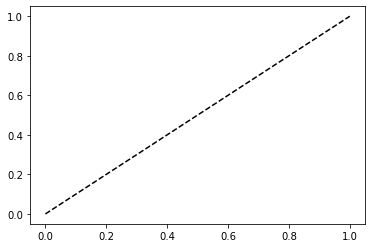

In [56]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras 597 (area = {:.3f})'.format(auc_keras_597))
plt.plot(fpr_keras, tpr_keras, label='Keras 1057 (area = {:.3f})'.format(auc_keras_1057))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 4 - NN_Bilanciato

In [57]:
model1_sb_1057 = build_model_1(xtrain_sb_1057)
history1_sb_1057 = model1_sb_1057.fit(xtrain_sb_1057, ytrain_sb_1057, validation_data=(xtest_sb_1057, ytest_sb_1057), epochs=30, batch_size=10).history

model2_sb_1057 = build_model_2(xtrain_sb_1057)
history2_sb_1057 = model2_sb_1057.fit(xtrain_sb_1057, ytrain_sb_1057, validation_data=(xtest_sb_1057, ytest_sb_1057), epochs=30, batch_size=50).history

NameError: name 'xtrain_sb_1057' is not defined

In [58]:
test_loss_1_sb_1057, test_auc_1_sb_1057 = model1_sb_1057.evaluate(xtest_sb_1057, ytest_sb_1057)
test_loss_2_sb_1057, test_auc_2_sb_1057 = model2_sb_1057.evaluate(xtest_sb_1057, ytest_sb_1057)

print('Loss %f, AUC %f' % (test_loss_1_sb_1057, test_auc_1_sb_1057))
print('Loss %f, AUC %f' % (test_loss_2_sb_1057, test_auc_2_sb_1057))

NameError: name 'model1_sb_1057' is not defined

In [59]:
allModels_sb_1057, r_sb_1057, model_sb_1057 = GridSearch(xtrain_sb_1057, ytrain_sb_1057, param_list, cv=3, rand=False)

NameError: name 'xtrain_sb_1057' is not defined

In [60]:
pred_sb_1057 = model_sb_1057.predict_classes(xtest_sb_1057)

NameError: name 'model_sb_1057' is not defined

In [61]:
y_pred_keras_sb_1057 = model_sb_1057.predict(xtest_sb_1057).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(ytest_sb_1057, y_pred_keras_sb_1057)
auc_keras_sb_1057 = auc(fpr_keras, tpr_keras)

NameError: name 'model_sb_1057' is not defined

NameError: name 'auc_keras_sb_597' is not defined

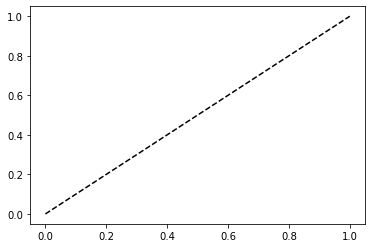

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras bilancato 597 (area = {:.3f})'.format(auc_keras_sb_597))
plt.plot(fpr_keras, tpr_keras, label='Keras bilancato 1057 (area = {:.3f})'.format(auc_keras_sb_1057))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()